In [1]:
from QIP import *

In [2]:
def grovers(goal_state, num_iterations):
    num_qubits = len(goal_state)+1
    circuit = QCircuit(num_qubits)
    
    # h on all except ancilla
    for qubit in range(num_qubits-1):
        circuit.h(qubit)
    # NOT on ancilla    
    circuit.x(num_qubits-1)
    # grover iteration
    for grover_iteration in range(num_iterations):
        # phase flip ancilla controlled by bitstring of goal state
        circuit.apply_to_circuit(arbitrary_U(x,num_qubits,[num_qubits-1],control_bitstring=goal_state))
        
        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)

        # phase flip ancilla if state is all zeros
        circuit.apply_to_circuit(arbitrary_U(z,num_qubits,[num_qubits-1],control_bitstring='0'*len(goal_state)))

        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)
    return circuit

Grover's algorithm on 4 qubits

In [3]:
grovers_circuit_4_bits = grovers('1101',int(2**4))

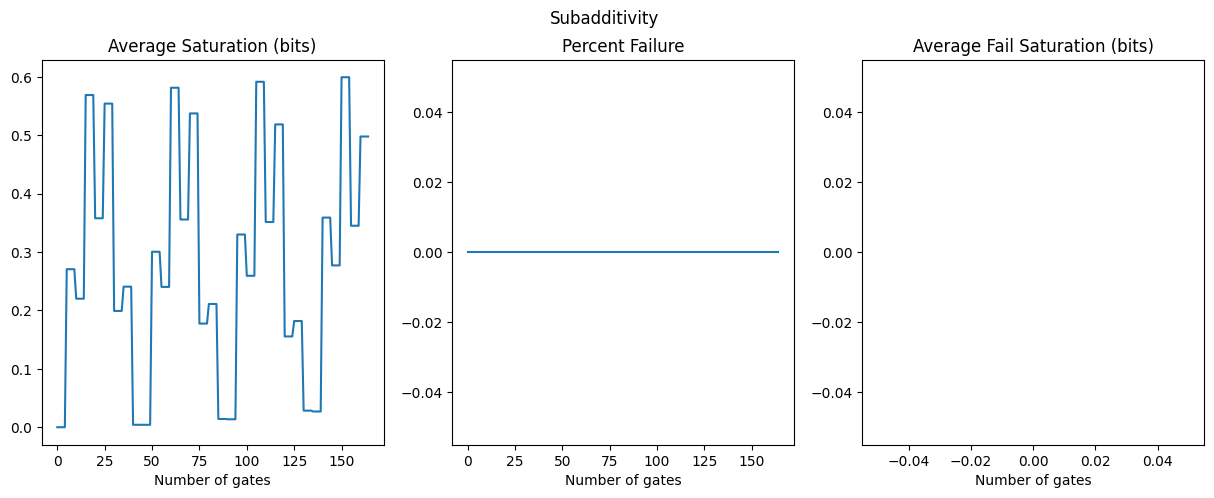

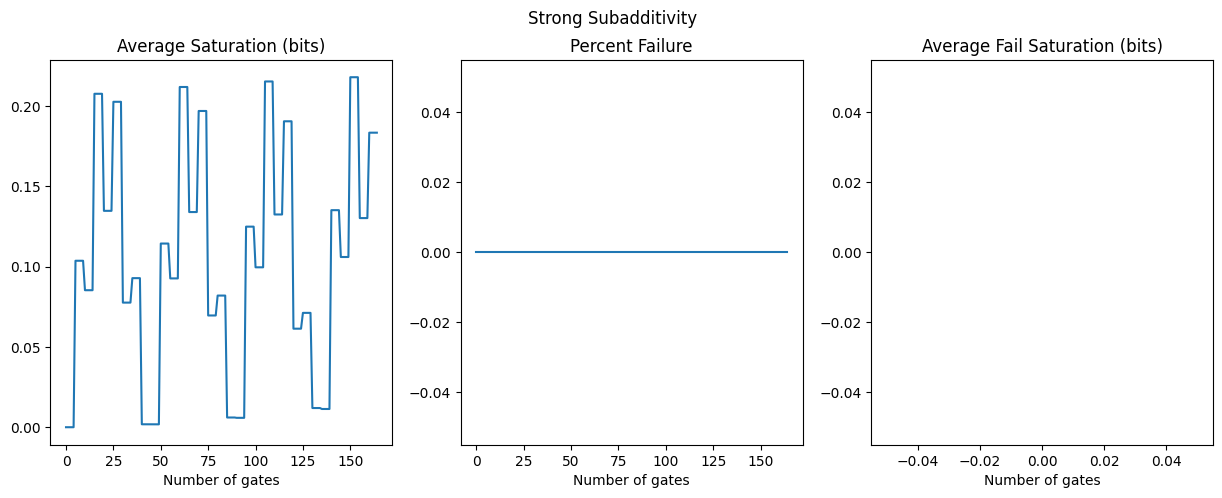

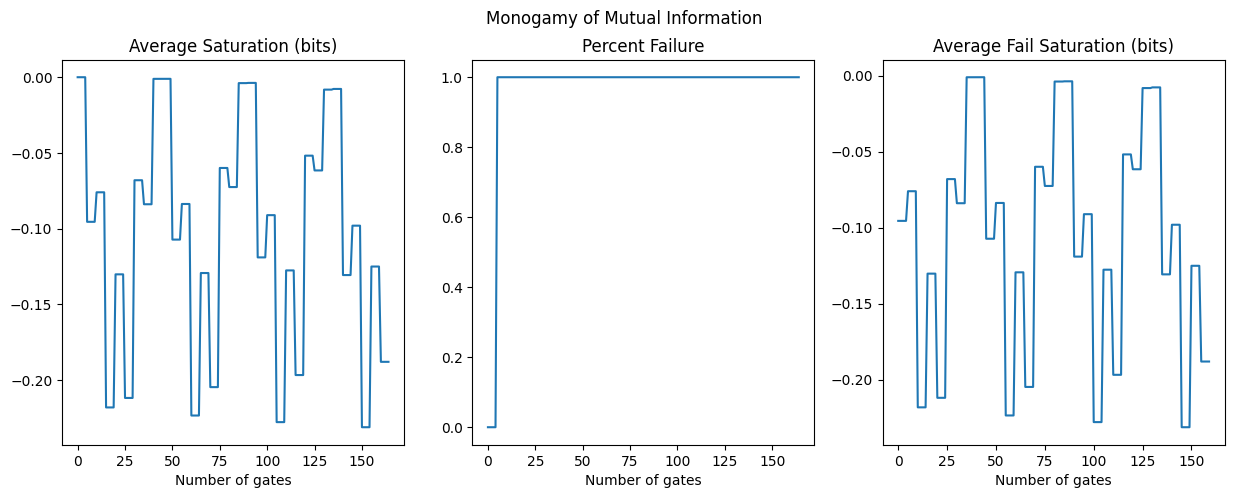

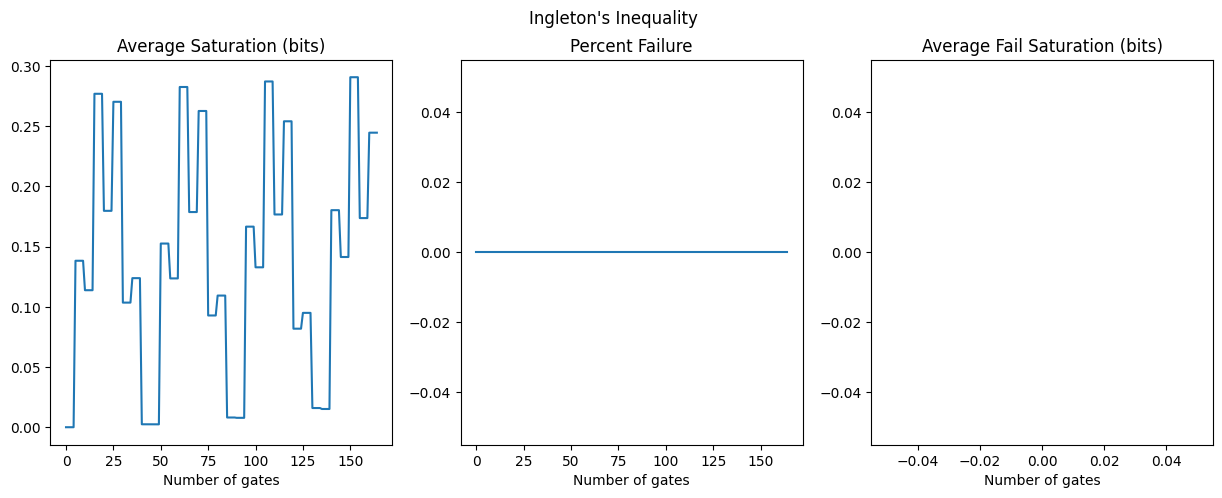

In [4]:

grovers_circuit_4_bits.plot_saturations(savefiles=True,folder="grovers-4/")


Grover's algorithm on 5 qubits

In [5]:
grovers_circuit_5_bits = grovers('11010',int(2**4))

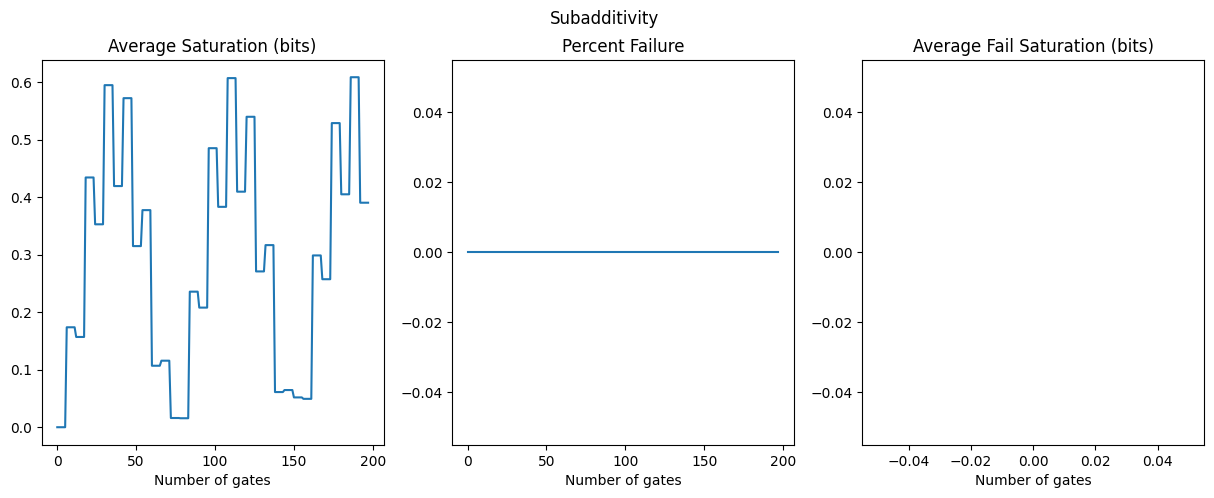

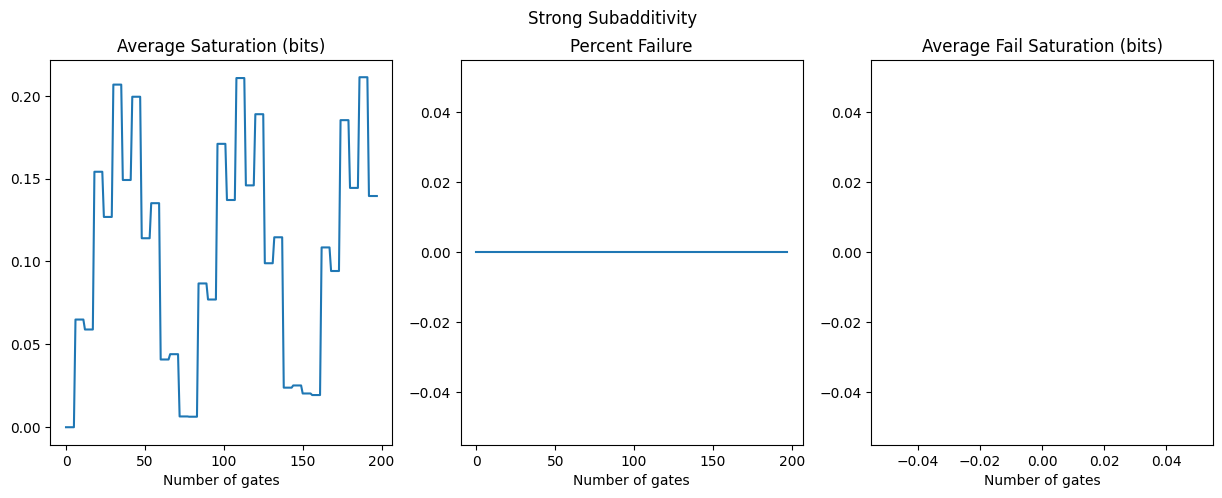

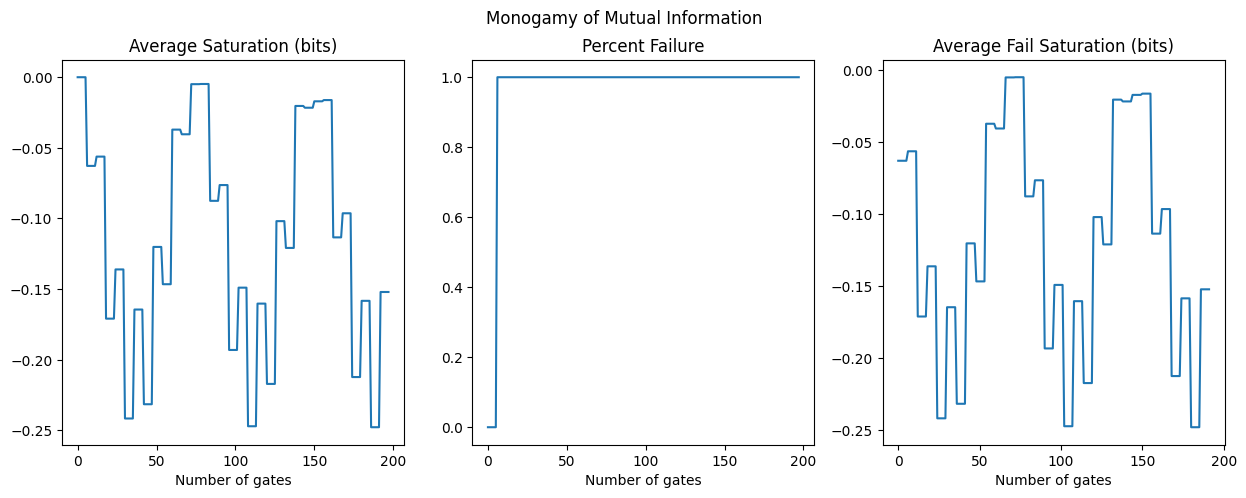

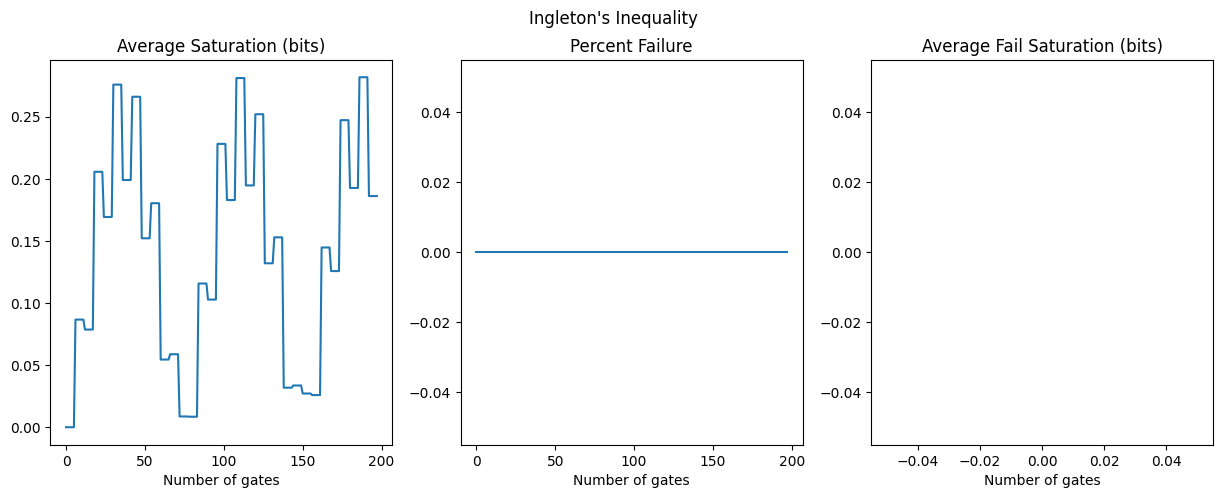

In [9]:

grovers_circuit_5_bits.plot_saturations(savefiles=True,folder="grovers-5/")


Grover's algorithm on 6 qubits

In [7]:
grovers_circuit_6_bits = grovers('110101',int(2**4))


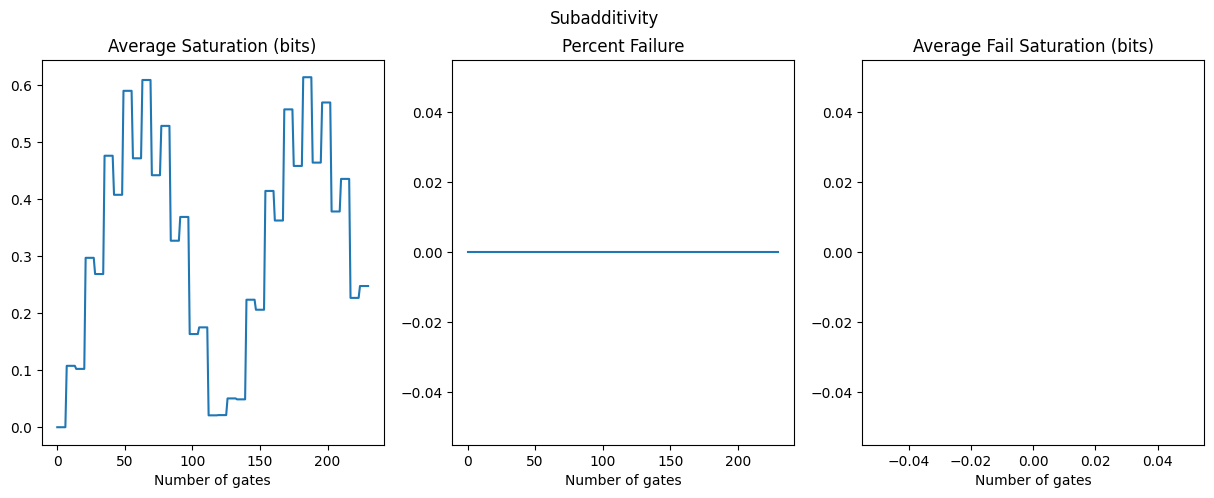

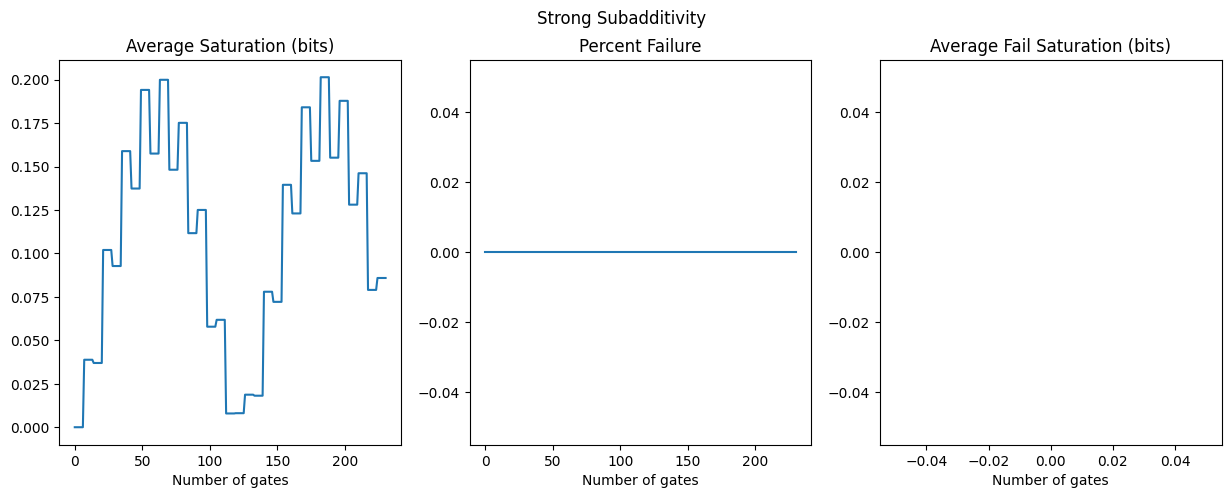

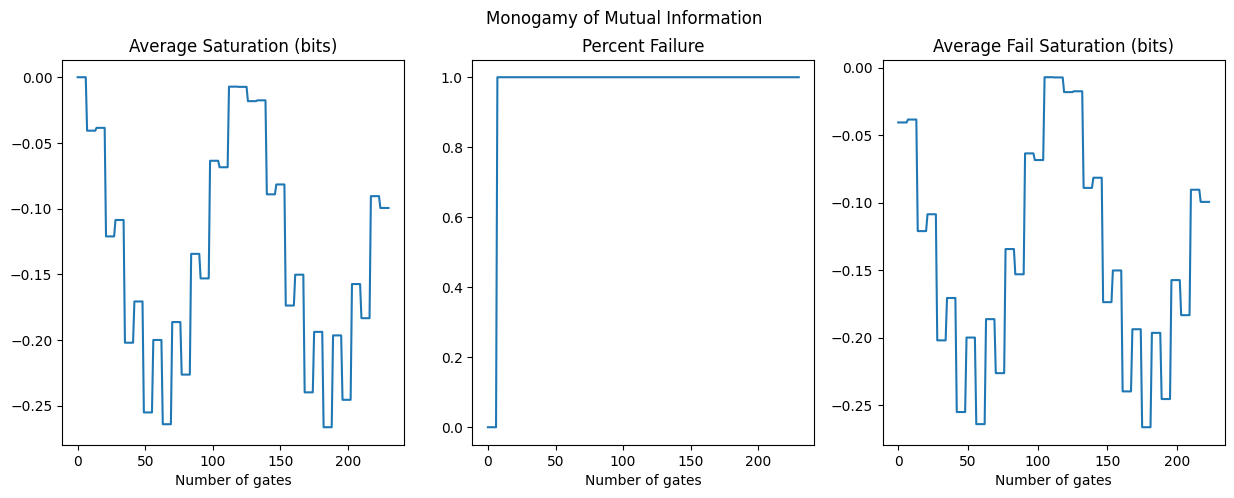

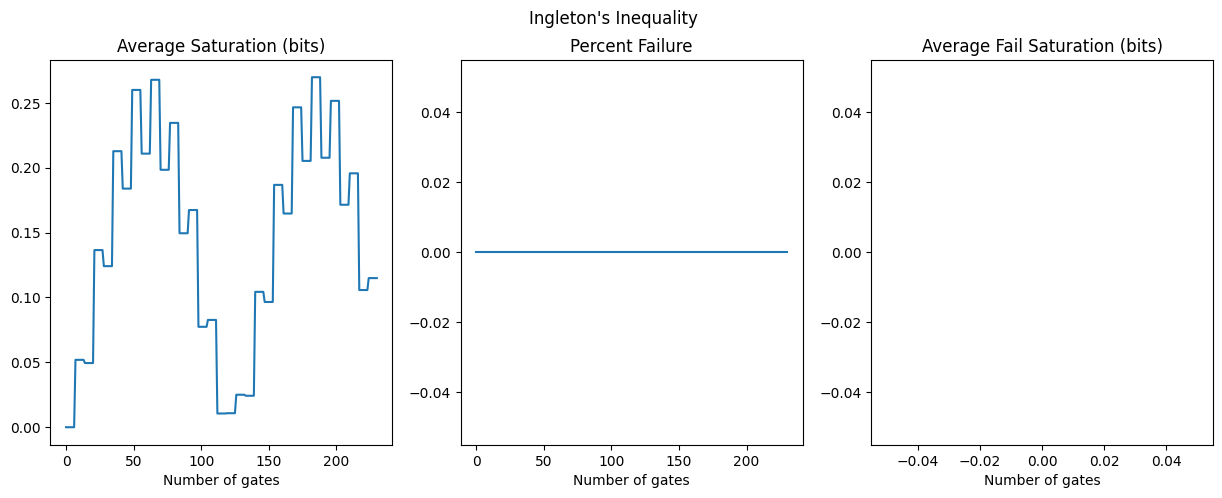

In [10]:
grovers_circuit_6_bits.plot_saturations(savefiles=True,folder="grovers-6/")

In [12]:
def qft(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    for i in range(circuit_size):
        circuit.h(i)
        
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [13]:
qft_circuit = qft(6)

/home/valeryh/QI_Research/QIP.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  p_A[i][k] = p_A[i][k]+ p[int(bra_bitstring,2)][int(ket_bitstring,2)]


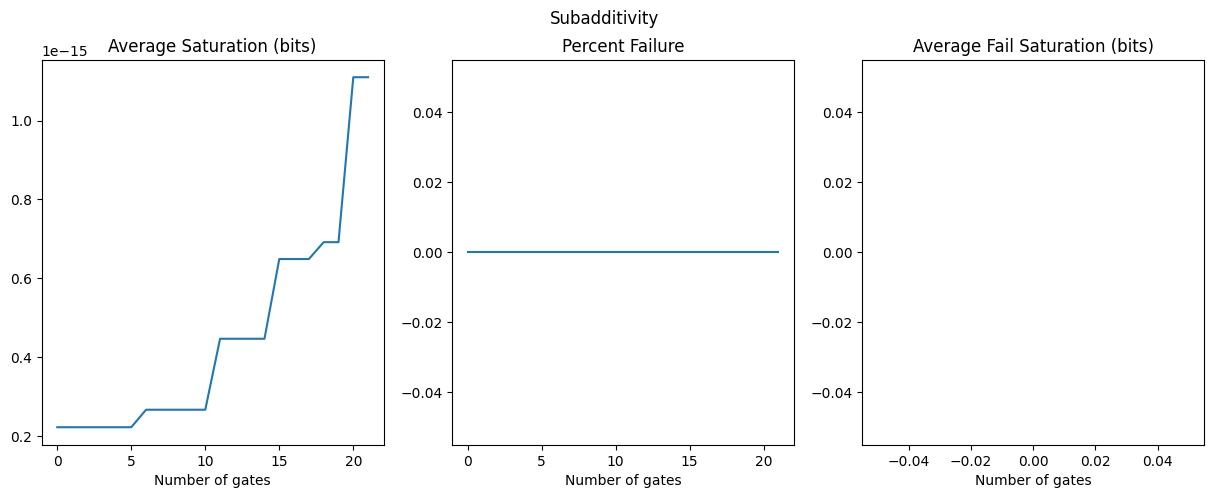

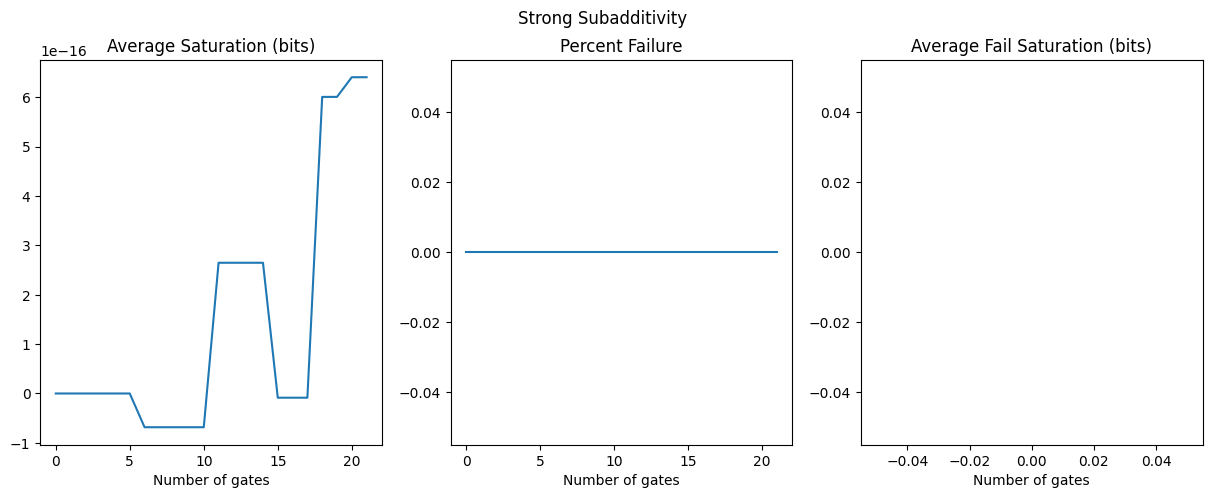

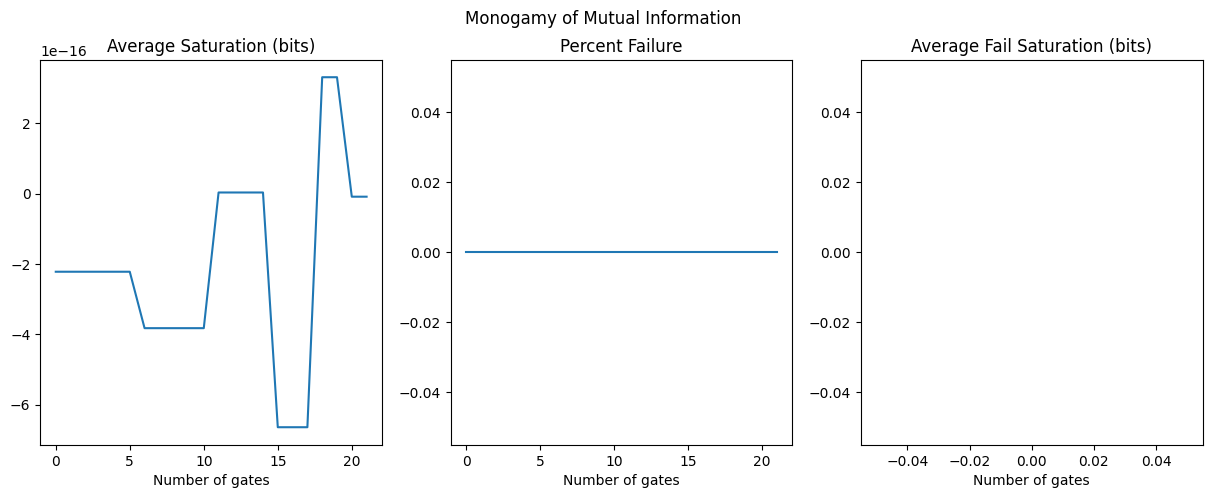

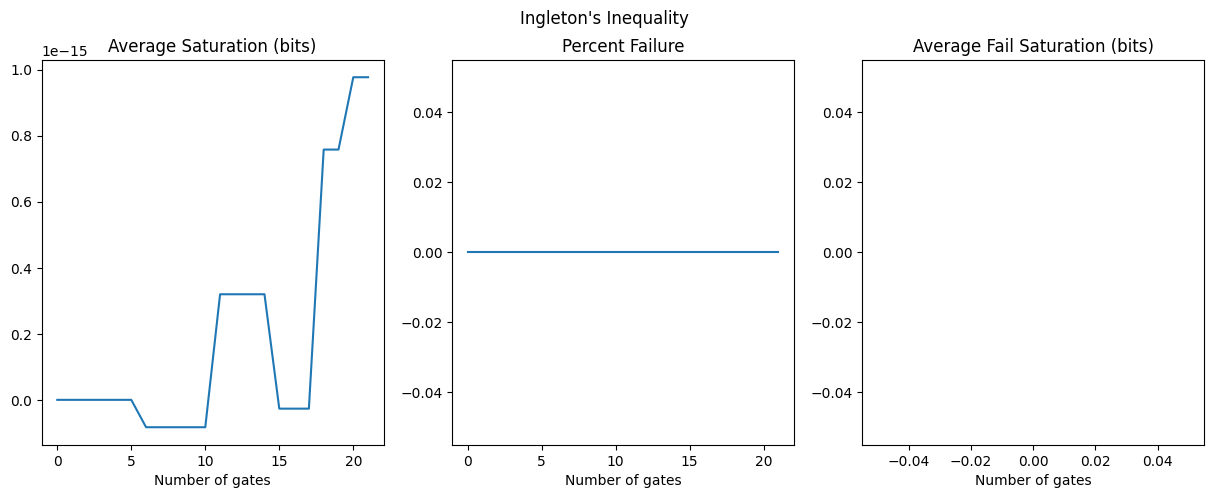

In [15]:
qft_circuit.plot_saturations(savefiles=True,folder="qft-6/")

In [16]:
def qft_inverse(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    
    # Hadamard on every qubit
    for i in range(circuit_size):
        circuit.h(i)
        
        # Controlled reverse-phase on each qubit 
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(-1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [17]:
qft_i_circuit = qft_inverse(6)

/home/valeryh/QI_Research/QIP.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  p_A[i][k] = p_A[i][k]+ p[int(bra_bitstring,2)][int(ket_bitstring,2)]


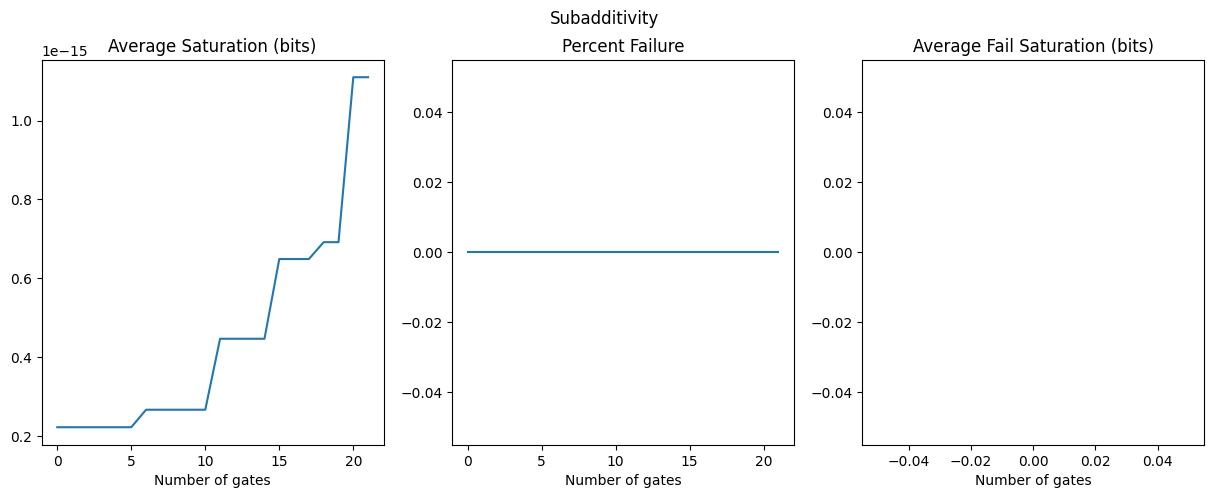

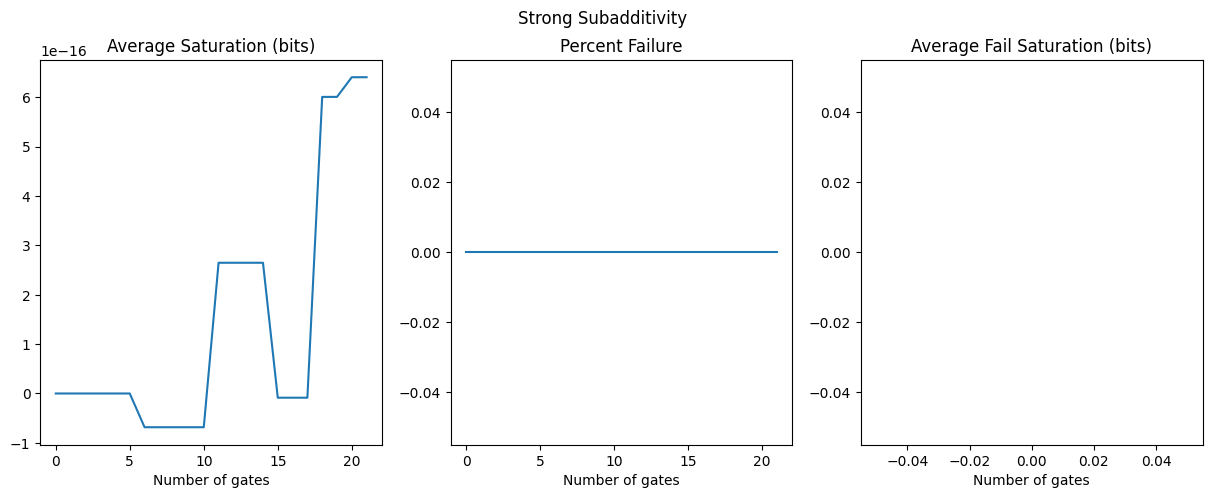

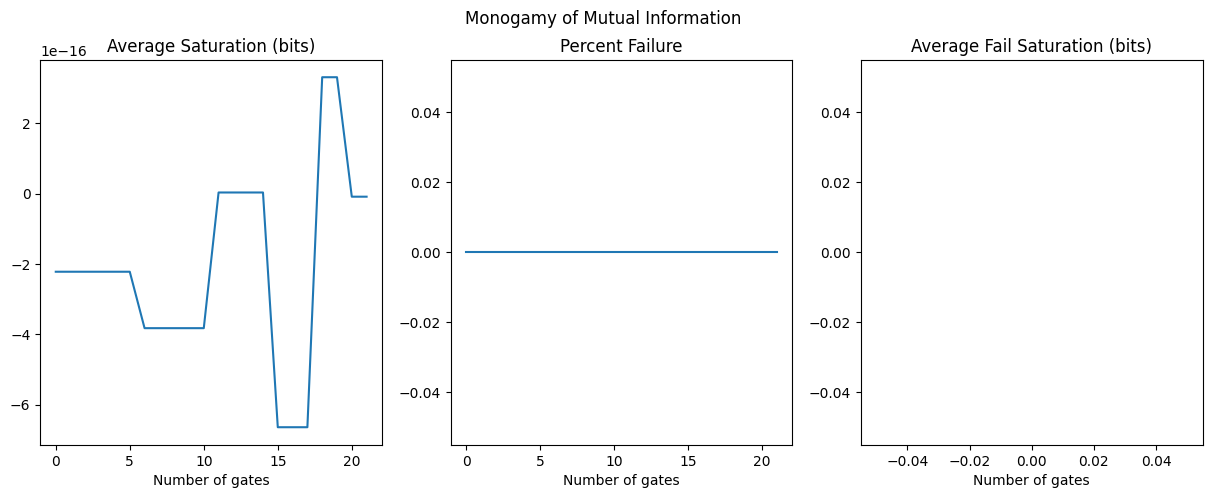

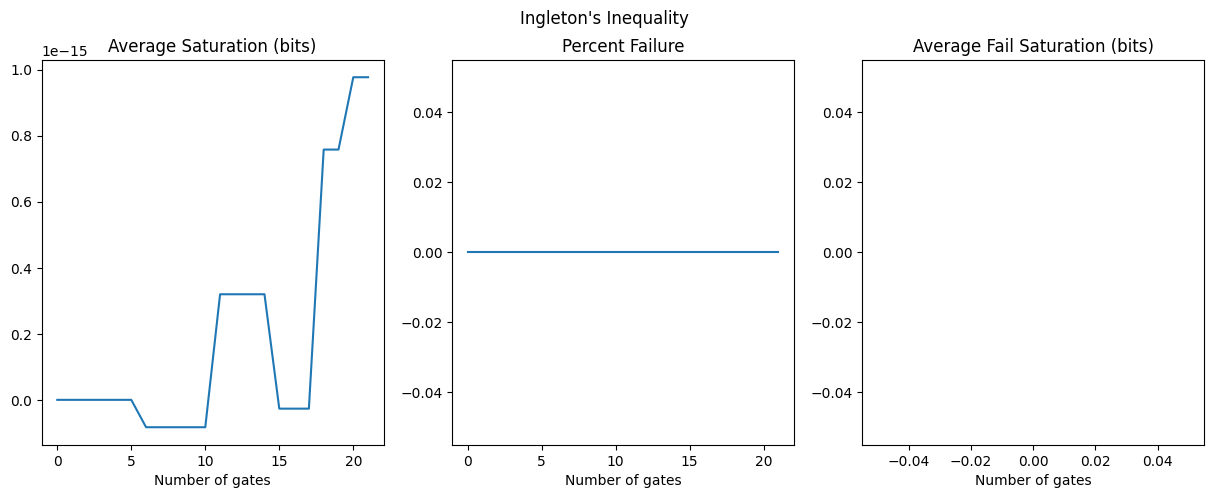

In [18]:
qft_i_circuit.plot_saturations(savefiles=True,folder="qft-i-6/")

In [24]:
def qpe(U,num_auxiliary_bits,eigvec):
    
    m = int(np.log2(np.shape(U)[0]))
    num_qubits = num_auxiliary_bits + m
    circuit = QCircuit(num_qubits,initial_state=np.kron(bitstrings_to_vector('0'*num_auxiliary_bits),eigvec))
    for i in range(num_auxiliary_bits):
        circuit.h(i)
    for k in range(num_auxiliary_bits):
        circuit.apply_to_circuit(arbitrary_U(U**(2**k),num_qubits,list(range(num_auxiliary_bits,num_qubits)),controls=[num_qubits-m-1-k]))
    qfti_circuit = qft_inverse(num_auxiliary_bits)
    #qfti_circuit.reverse_bits()
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,num_qubits,list(range(num_auxiliary_bits))))
    return circuit

In [29]:
def generate_random_unitary_matrix(n):
    """
    Generate a 2^n x 2^n random unitary matrix.
    """
    size = 2**n
    # Generate a random complex matrix
    random_matrix = np.random.randn(size, size) + 1j * np.random.randn(size, size)
    # Perform QR decomposition to obtain a unitary matrix
    q, _ = np.linalg.qr(random_matrix)
    return q
n = 3
U = generate_random_unitary_matrix(n)
eigenvalues, eigenvectors = np.linalg.eig(U)

qpe_circuit = qpe(U,3,eigenvectors[0])

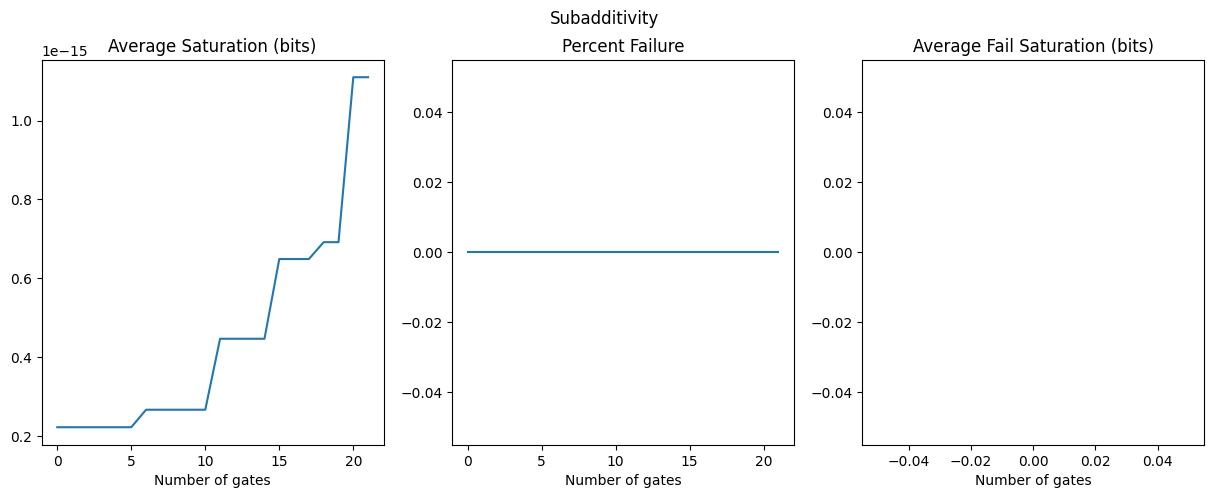

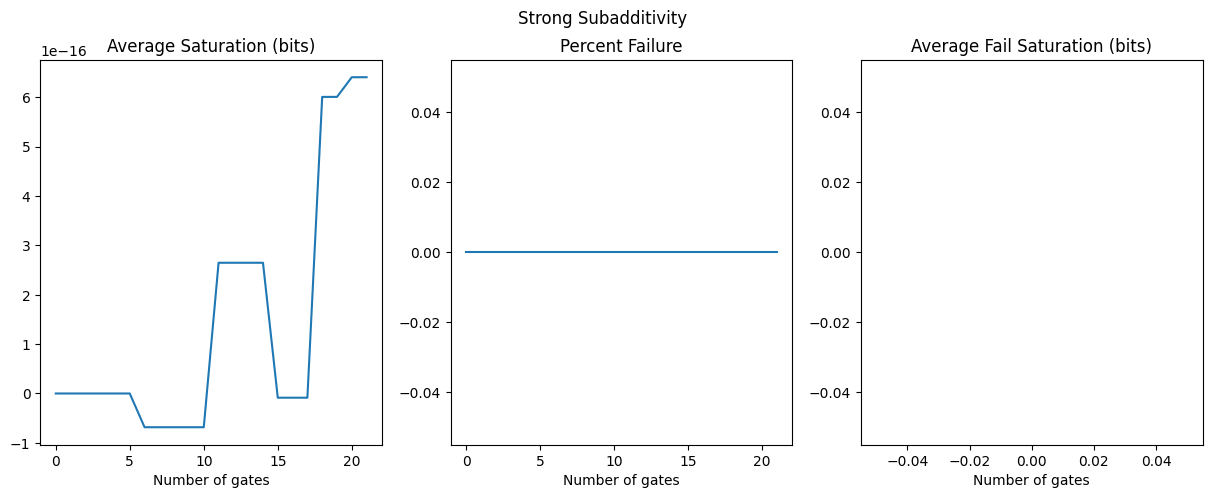

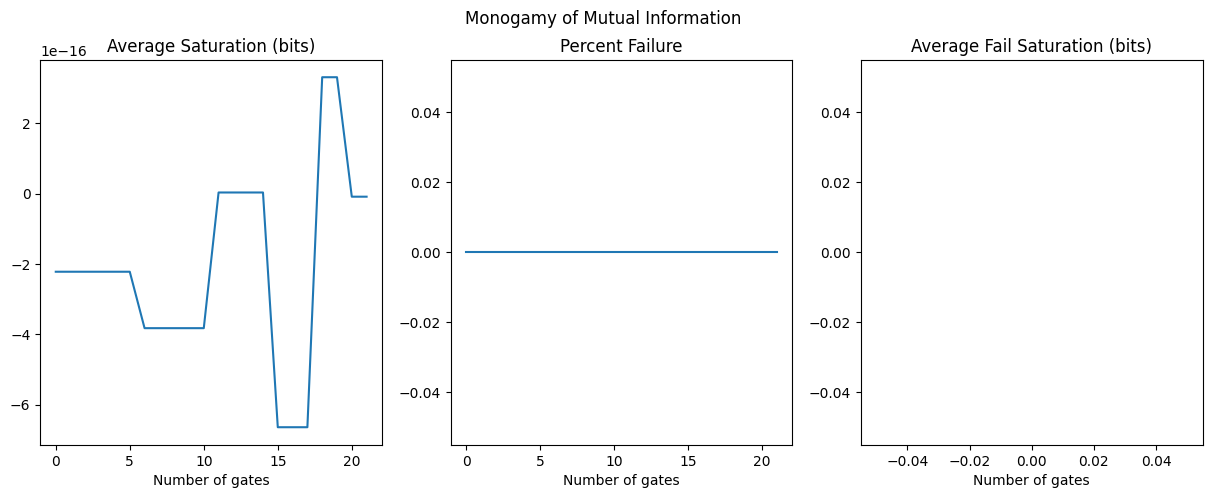

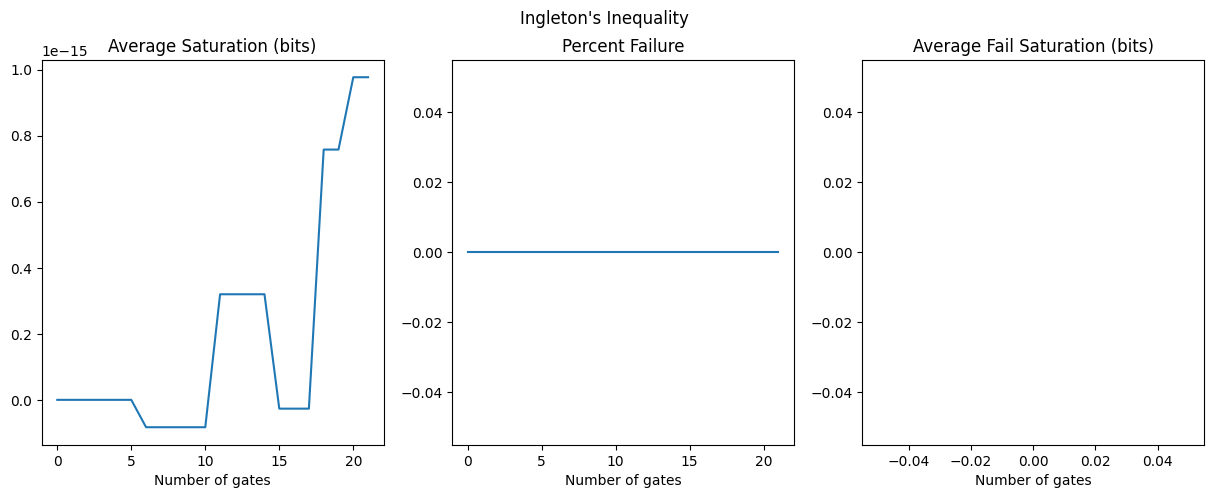

In [27]:
qft_i_circuit.plot_saturations(savefiles=True,folder="qpe-6/")

Shor's

In [9]:
#Here we build the unitary needed for Shor's. In each step of phase estimation we must construct a new one
def order_finding_U(a,n,N):
    U = np.zeros((2**n,2**n))
    for k in range(2**n):
        if k < N: 
            transformed_k = (a*k)%N
        else: transformed_k = k
        row = np.array(1.)
        for bit in int_to_bitstring(transformed_k,n):
            row = np.kron(row,qubit_map[bit])
        U[k]=row
    return U.T

def order_finding(a,N):
    
    # number of qubits in second register
    n = int(np.ceil(np.log2(N)))
    
    # accuracy and number of qubits in first register
    m = 2*n+1
    
    # now execute the circuit
    circuit = QCircuit(m+n)
    
    # phase estimation step 
    
    # second register starts as |1>
    for q in range(m,n+m):
        circuit.x(q)
    
    # hadamard on all inputs
    for q in range(m):
        circuit.h(q)
    
    # controlled unitaries
    for k in range(m):
        circuit.apply_to_circuit(arbitrary_U(order_finding_U(a**(2**k),n,N),n+m,list(range(m,n+m)),controls=[n-1-k]))
    
    # inverse qft
    qfti_circuit = qft_inverse(m)
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,n+m,list(range(m))))
    return circuit
    
    
    

    

In [7]:

# my method for the partial trace, reorder the density matrix such that the bits to be traced out are at the end, then use above formula

def reorder_U(circuit_size,bits):
    """_summary_

    Args:
        circuit_size (int): number of bits in circuit
        bits (list): bits to move to the end

    Returns:
        ndarray: unitary permutation matrix which reorders the given bits
    """
    lgm = np.zeros((2**circuit_size,2**circuit_size))
    for bitint in range(2**circuit_size):
        bitstring = int_to_bitstring(bitint,circuit_size)
        transformed_bitstring = [bitstring[i] for i in range(len(bitstring)) if i not in bits] + [bitstring[i] for i in bits]
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm

def partial_trace2(p,trace_out):
    """finds the reduced density matrix after tracing out the given indices

    Args:
        p (numpy.ndarray (2-d)): full density matrix
        trace_out (list): indices to trace out
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    sum = 0
    for j in range(2**d_b):
        vec = np.zeros(2**d_b)
        vec[j]=1.
        vec.shape=(2**d_b,1)
        # sum = sum + np.kron(np.eye(2**d_a),vec.conj().T)@reorder_U(d_b+d_a,trace_out).conj().T@p@reorder_U(d_b+d_a,trace_out)@np.kron(np.eye(2**d_a),vec)
        sum = sum + np.kron(np.eye(2**d_a),vec.conj().T)@p@np.kron(np.eye(2**d_a),vec)
    return sum


In [10]:
# a better method, turn the indices into bitstrings and sum over the bits given
def partial_trace(p,trace_out):
    """ finds the reduced density matrix given indices of bits to trace over

    Args:
        p (ndarray): density matrix to reduce
        trace_out (list): indices of bits to trace over

    Returns:
        ndarray: reduced density matrix after tracing out the given bits
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    p_A = np.zeros((2**d_a,2**d_a))
    for i in range(2**d_a):
        for k in range(2**d_a):
            for j in range(2**d_b):
                # build the bitstring of the indices, summing over only j
                bra_bitstring = ""
                ket_bitstring = ""
                ik_c = 0 # keep track of which binary digit of i,k 
                j_c = 0 # keep track of which binary digit of j, summed over
                for l in range(d_b+d_a):
                    if l in trace_out:
                        bra_bitstring = bra_bitstring + int_to_bitstring(j,d_b)[j_c]
                        ket_bitstring = ket_bitstring + int_to_bitstring(j,d_b)[j_c]
                        j_c = j_c + 1
                    else:
                        bra_bitstring = bra_bitstring + int_to_bitstring(i,d_a)[ik_c]
                        ket_bitstring = ket_bitstring + int_to_bitstring(k,d_a)[ik_c]
                        ik_c = ik_c + 1
                p_A[i][k] = p_A[i][k]+ p[int(bra_bitstring,2)][int(ket_bitstring,2)]
                # equivalent 'mathy' way but slower:
                # bra = bitstrings_to_vector(bra_bitstring)
                # bra.shape=(2**(d_b+d_a),1)
                # bra = bra.conj().T
                # ket = bitstrings_to_vector(ket_bitstring)
                # ket.shape=(2**(d_b+d_a),1)
                # p_A[i][k] = p_A[i][k]+bra@p@ket
    return p_A


In [5]:
matrix = np.random.random((32,32))


In [9]:
import time
s=time.time()
partial_trace2(matrix,[1,3])
e=time.time()
print(e-s)

0.0005085468292236328


In [11]:
s=time.time()
partial_trace(matrix,[1,3])
e=time.time()
print(e-s)

0.0015652179718017578
